# Diet Hadrade

Humanitarian crises, along with both natural and man-made disasters show no sign of abating in the near term given ongoing changes to the planet and society. Yet ever improving machine learning techniques hold the possibility of blunting some of the harshest impacts of future crises.  Diet Hadrade provides a lightweight mechanism for leveraging remote sensing imagery and machine learning techniques to aid in humanitarian assistnace and disaster response (HADR) in in austere environments. In a disaster scenario where communications are unreliable, overhead imagery often provides the first glimpse into what is happening on the ground, so analtics with such imagery can prove very valuable.  Specifically, the rapid extraction of both vehicles and road networks from overhead imagery allows a host of interesting problems to be tackled, such as congestion mitigation, optimized logistics, evacuation routing, etc.  

A reliable proxy for human population density is critical for effectiv response to natural disasters and humanitarian crises 
A multitude of efforts, such as [SpaceNet](https://spacenet.ai), have striven to improve foundation mapping of building footprints from satellite imagery, which can subsequently be used to population density estimates, pre/post disaster baselines, and numerous other analytics.  Yet while buildings are useful for longer term planning, they rarely provide  information on highly dynamic timescales.  

Automobiles provide an alternative, and in some cases quite attractive, proxy for human population.  Many buildings (eg. office parks or industrial zones) remain unocuppied for large portions of the week.  People tend to stay near their cars, however, so knowledge of where cars are located in real-time provides value in disaster response scenarios.  Simply knowing where vehicles are located is extremely helpful in order to ascertain where resources should be ideally deployed.  In this project, we deploy the [YOLTv5](https://github.com/avanetten/yoltv5) codebase to rapidly identify and geolocate vehicles over large areas.  Geolocations of all the vehicles in an area allow responders to prioritize response areas.

Yet vehicle detections really come into their own when combined with road network data.  We use the [CRESI](https://github.com/avanetten/cresi) framework to extract road networks with travel time estimates, thuse permitting optimized routing.  The CRESI codebase is able to extract roads with only imagery, so flooded areas or obstructed roadways will sever the CRESI road graph; this is crucial for post-disaster scenarios where existing road maps may be out of date and the route suggested by navigation services may be impassable or hazardous.  

Diet Hadrade provides a number of graph theory analytics that combine the CRESI road graph with the YOLTv5 locations of vehicles.  This allows congestion to be estimated, as well as optimal lines of communication and evacuation scenarios.  In the cells below we provide an example of the analytics that can be peformed with this codebase.  Of particular note, the test city select below (Dar Es Salamm) is not represented in any of the training data for either CRESI or YOLTv5.  The implication is that the Diet Hadrade methodology is quite robust and can be applied immediately to unseen geographies whenever a new need may arise.





# 0. Creating the SageMaker StudioLab environment

    # install yolov5
    # https://github.com/ultralytics/yolov5
    cd /home/studio-lab-user
    conda activate default
    git clone https://github.com/ultralytics/yolov5
    cd yolov5
    pip install -r requirements.txt  # install

    # update with geo packages
    conda install -c conda-forge gdal
    conda install -c conda-forge osmnx
    conda install -c conda-forge osmnx=0.12 
    conda install -c conda-forge scikit-image
    conda install -c conda-forge statsmodels
    conda install -c conda-forge matplotlib
    conda install -c conda-forge ipykernel 
    pip install torchsummary
    pip install utm
    pip install numba
    pip install jinja2==2.10
    


-----
# 2. Download Data

### A. Model Weights

CRESI provided the algorithmic baseline for the [SpaceNet 5 Challenge](https://spacenet.ai/sn5-challenge/).  While challenge participants managed to improve the perforamnce of the CRESI baseline by about 5%, we will use the original CRESI model for this exercise, as it has by far the fastest runtime (see [this blog](https://medium.com/the-downlinq/spacenet-5-winning-model-release-end-of-the-road-fd02e00b826c) for further details.) Model weights are freely available on AWS.  The [AWS CLI](https://aws.amazon.com/cli/) tool is installed within the docker container, so you once you configure this tool (via ```aws configure```), simply execute the cell below:

### B. Testing Data

Since the pre-trained model weights are available, we need not download the SpaceNet training data.  Instead, we will just download the testing data.  For this exercise, we'll explore SpaceNet Area of Interest (AOI) \#10: Dar Es Salaam.  This city was withheld for testing purposes in SpaceNet 5, meaning that the pre-trained model has not been trained on this city whatsoever.  To download the data (25 GB):

In [1]:
!aws s3 cp --recursive s3://spacenet-dataset/AOIs/AOI_10_Dar_Es_Salaam/PS-MS/ {test_im_raw_dir}

/bin/bash: aws: command not found


----

# 3. Execute Inference


### yoltv5

    cd /home/studio-lab-user/geodesic/src/yoltv5/yoltv5
    time ./test.sh /home/studio-lab-user/geodesic/cfg/yoltv5_test_studio_lab.yaml

### cresi

    cd /home/studio-lab-user/geodesic/src/cresi/cresi
    JSON=/home/studio-lab-user/geodesic/cfg/cresi_test_studio_lab.json
    time ./test.sh $JSON


-----
# 4. Diet Hadrade

In [9]:
import os
import sys
import json
import skimage.io
import osmnx as ox
import numpy as np
import pandas as pd
import scipy.spatial
import networkx as nx
from imp import reload
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
#%matplotlib inline  
%matplotlib notebook

local = True

# StudioLab
if not local:
    src_dir = '/home/studio-lab-user/geodesic/src/diet_hadrade'
    bbox_path = '/home/studio-lab-user/geodesic/results/test0/yoltv5/geojsons_geo_0p15/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_3857.geojson'
    graph_path = '/home/studio-lab-user/geodesic/results/test0/cresi/graphs_speed/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_3857.gpickle'
    im_path = '/home/studio-lab-user/geodesic/data/test_imagery/input/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip.tif'
# Local
else:
    src_dir = '/Users/ave/projects/geodesic/src/diet_hadrade/src'
    # bbox_path = '/Users/ave/projects/geodesic/results/test0/yoltv5/geojsons_geo_0p15/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_EPSG:4326.geojson'
    bbox_path = '/Users/ave/projects/geodesic/results/test0/yoltv5/geojsons_geo_0p15/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_3857.geojson'
    graph_path = '/Users/ave/projects/geodesic/results/test0/cresi/graphs_speed/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_3857.gpickle'
    im_path = '/Volumes/ExternalSSD/projects/spacenet/data/AOI_10_Dar_Es_Salaam/PS-RGB_8bit_clip/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip.tif'
    
sys.path.append(src_dir)
import diet_hadrade
import graph_utils
import utils
import plot_graph_plus_im

In [10]:
max_dist_m = 5  # maximum distance from a roadway for a car (meters)
G, df_bbox, g_node_props_dic, kd_idx_dic, kdtree = \
    diet_hadrade.load_data(graph_path, bbox_path, 
                           max_dist_m=max_dist_m)

Loading graph pickle: /Users/ave/projects/geodesic/results/test0/cresi/graphs_speed/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_3857.gpickle ...
Num G_gt_init.nodes(): 1446
Num G_gt_init.edges(): 1719
('G random node props:', 14134, ':', {'osmid': 14134, 'x_pix': 5498.0, 'y_pix': 6276.0, 'lon': 39.26736359998074, 'lat': -6.774942600002479, 'utm_east': 529544.6113706235, 'utm_zone': 37, 'utm_letter': 'M', 'utm_north': 9251122.199885933, 'x': 4371222.920744183, 'y': -755946.813400082})
G random edge props: (15245, 15257) : {'start': 15245, 'start_loc_pix': (12.0, 7569.0), 'end': 15257, 'end_loc_pix': (2.0, 7583.0), 'length_pix': 17.204650534085253, 'wkt_pix': 'LINESTRING (12 7569, 2 7583)', 'geometry_pix': <shapely.geometry.linestring.LineString object at 0x1880dc1c0>, 'osmid': 1349, 'geometry_latlon_wkt': <shapely.geometry.linestring.LineString object at 0x1880dc1f0>, 'geometry_utm_wkt': <shapely.geometry.linestring.LineString object at 0x1880dc250>, 'length_latlon': 4.645255643859071e-05, 'len

In [11]:
# Explore a random edge
for u, v, data in G.edges(keys=False, data=True):
    print("u:", u, "v", v)
    for key,val in data.items():
        print(key, val)
    break

u: 10000 v 10004
start [10000, 10001, 10002, 10003]
start_loc_pix [(7321.0, 55.0), (7350.0, 2.0), (7290.0, 127.0), (7306.0, 95.0)]
end [10001, 10002, 10003, 10004]
end_loc_pix [(7321.0, 55.0), (7283.0, 134.0), (7290.0, 127.0), (7306.0, 95.0)]
length_pix 148.81183117116882
wkt_pix LINESTRING (7350 2, 7321 55, 7306 95, 7290 127, 7283 134)
geometry_pix LINESTRING (7350 2, 7321 55, 7306 95, 7290 127, 7283 134)
osmid 0
geometry_latlon_wkt LINESTRING (39.27236399997931 -6.7580028000011, 39.27218309997936 -6.75835920000113)
geometry_utm_wkt LINESTRING (530098.2259186266 9252994.531477312, 530078.2129649626 9252955.143834233)
length_latlon [2.672863633032664e-05, 9.659813662798822e-05, 0.00016312112064330534, 0.00011534405056663028]
length_utm 44.180366019609565
length 44.180366021908
utm_zone 37
utm_letter M
geometry LINESTRING (4371779.562725785 -754047.8565333373, 4371759.425029906 -754087.8083988362)
geometry_wkt LINESTRING (530098.2259186261 -747005.4685300498, 530078.2129649599 -747044.8

im_test.shape: (11111, 11770, 3)
Begin plotting the graph...
Drew the graph edges in 0.14 seconds


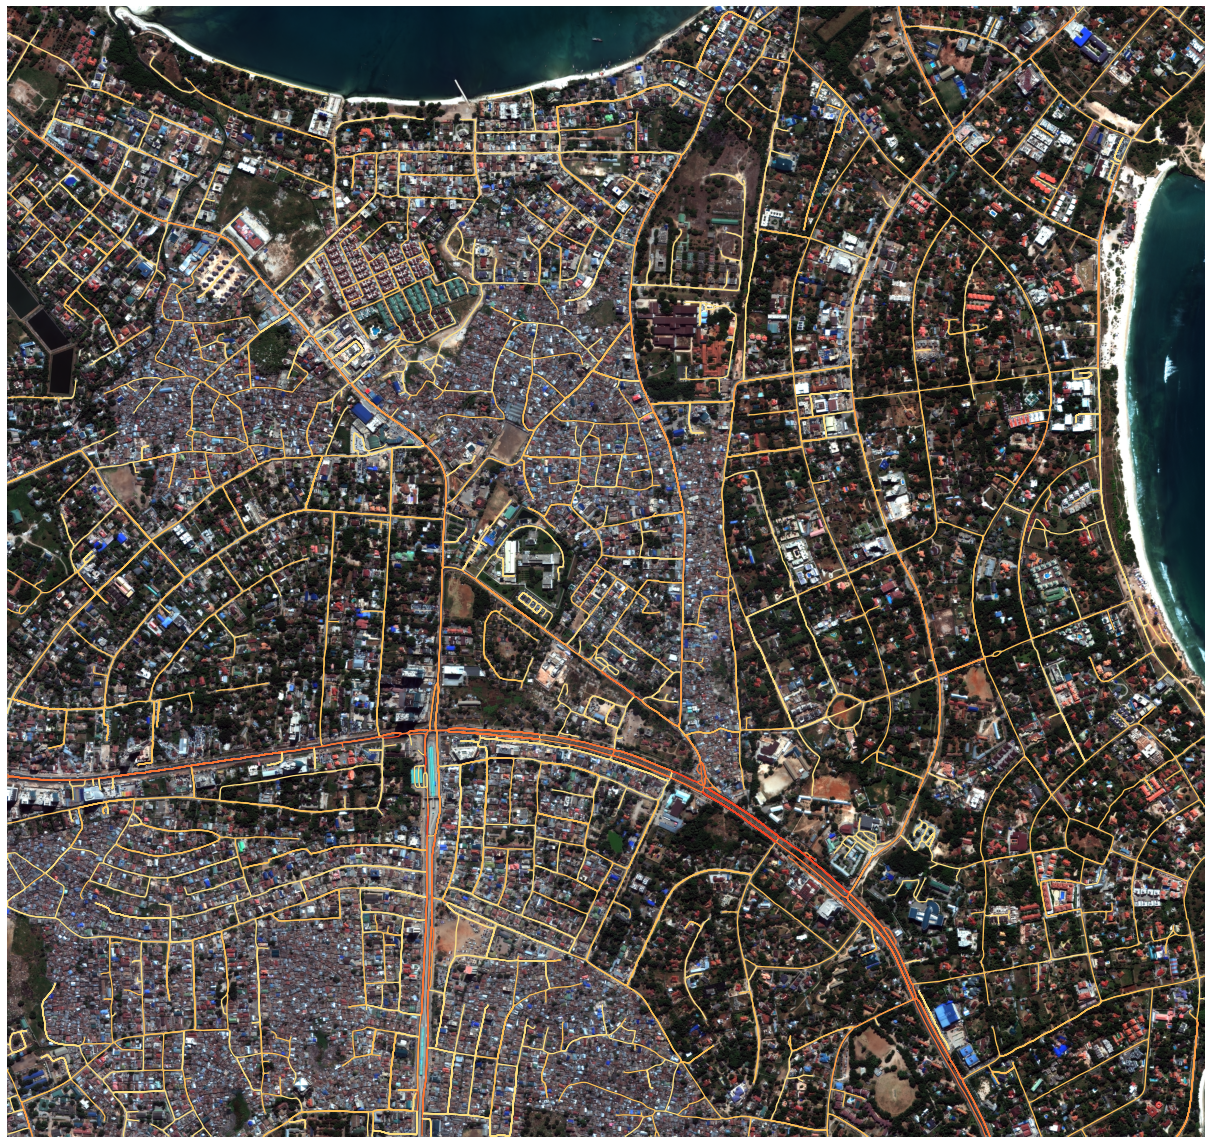

In [12]:
# Plot the graph with the image in the background
reload(plot_graph_plus_im)

outpath_im = os.path.join(src_dir, 'roads.png')
im_test = skimage.io.imread(im_path).astype(np.uint8)
print("im_test.shape:", im_test.shape)

# plot settings
fig_height=16
node_color='gray'   
edge_color='#bfefff'   # lightblue
node_size=10
node_alpha=1
edge_color_key = 'inferred_speed_mph'
edge_linewidth=1.3
edge_alpha=1
route_color='blue'
orig_dest_node_color=('green', 'red')
orig_dest_node_alpha=0.8
route_linewidth=5*edge_linewidth
orig_dest_node_size=400
dpi=500
verbose = True
# plt.close()
%matplotlib inline

color_dict, color_list = plot_graph_plus_im.make_color_dict_list()
fig, ax = plot_graph_plus_im.plot_graph_pix(G, im=im_test, fig_height=fig_height, fig_width=None, 
                           node_size=node_size, node_alpha=node_alpha, node_color=node_color, 
                           edge_linewidth=edge_linewidth, edge_alpha=edge_alpha,
                           edge_color_key=edge_color_key, color_dict=color_dict,
                           default_dpi=dpi,
                           show=False, save=False,
                           verbose=verbose)
plt.tight_layout()
# plt.savefig(outpath_im)
plt.show()

['Bus', 'Small_Vehicle', 'Truck']

Begin plotting the graph...
Drew the graph edges in 0.34 seconds


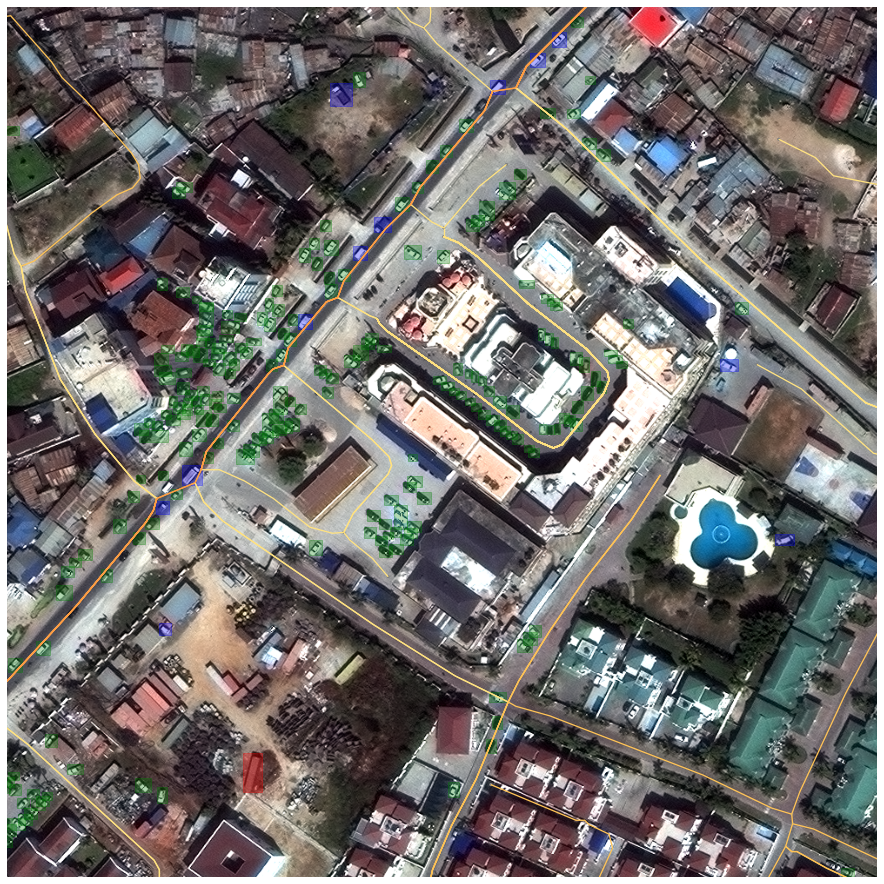

In [24]:
# plot vehicles plus roads

# get unique classes
uni_v = list(np.unique(df_bbox['Category'].values))
display(uni_v)
vehicle_color_dict = {
    'Small_Vehicle': 'green',
    'Bus': 'red',
    'Truck': 'blue'}
alpha = 0.3
v_boxes = [Rectangle((x0, y0), x1-x0, y1-y0)
                  for x0, x1, y0, y1 in zip(df_bbox['x0_pix'].values, 
                                            df_bbox['x1_pix'].values,
                                            df_bbox['y0_pix'].values,
                                            df_bbox['y1_pix'].values)]
facecolors = [vehicle_color_dict[z] for z in df_bbox['Category'].values]
# Create patch collection with specified colour/alpha
pc_v = PatchCollection(v_boxes, facecolor=facecolors, alpha=alpha,
                     edgecolor=facecolors)

# plot roads first
fig, ax = plot_graph_plus_im.plot_graph_pix(G, im=im_test, fig_height=16, fig_width=None, 
                           node_size=node_size, node_alpha=node_alpha, node_color=node_color, 
                           edge_linewidth=edge_linewidth, edge_alpha=edge_alpha,
                           edge_color_key=edge_color_key, color_dict=color_dict,
                           default_dpi=dpi,
                           show=False, save=False,
                           verbose=verbose)
# Add collection to axes
ax.add_collection(pc_v)

# OPTIONAL: zoom in on a portion of the plot (for viewing purposes)
ax.set_xlim(2800, 3800)
ax.set_ylim(2800, 3800)

plt.show()

----

## Traffic

We can combine the car detections with the road network to infer how congested certain areas are.  Congestion information is important for everday life, but also crucially important in disaster response scenarios when roads may become impassable due to both natural phenomena as well as traffic.

In [13]:
# Now let's estimate the congestion based upon the cars detected on the roadways
G, edge_update_dict = diet_hadrade.update_G(G)

Computing traffic...
Time to create k-d tree: 0.004423856735229492 seconds


Begin plotting the graph...
Drew the graph edges in 0.13 seconds
Begin plotting the graph...
Drew the graph edges in 0.12 seconds


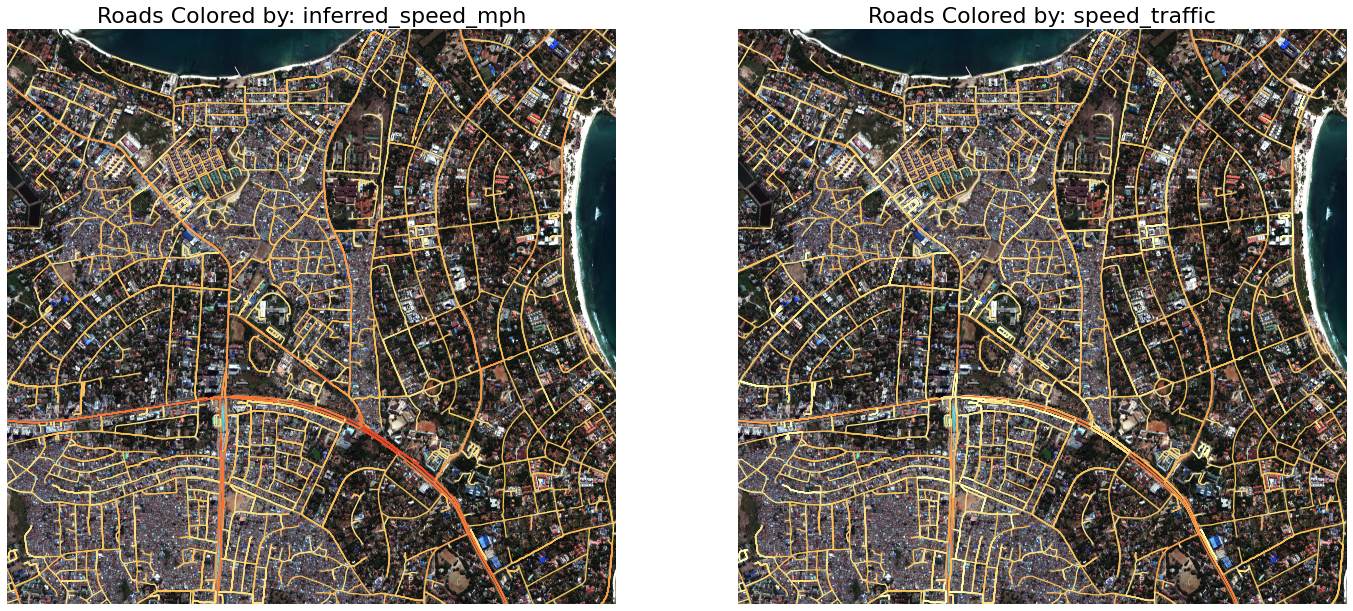

In [14]:
# Now let's plot the inferred traffic congestion

rowplot = True
fig_height, fig_width = 12, 12
plt.close()
if rowplot:
    # side by side (easier to compare)
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(2*fig_width, fig_height))  
else:
    # vertically aligned (larger)
    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(fig_width, 2.1*fig_height))  

for ax, weight in zip((ax0, ax1), ('inferred_speed_mph', 'speed_traffic')):
    fig, ax = plot_graph_plus_im.plot_graph_pix(G, im=im_test, fig_height=fig_height, fig_width=None, 
                           node_size=node_size, node_alpha=node_alpha, node_color=node_color, 
                           edge_linewidth=edge_linewidth, edge_alpha=edge_alpha,
                           edge_color_key=weight, color_dict=color_dict,
                           default_dpi=dpi,
                           show=False, save=False,
                           ax=ax, fig=fig,
                           verbose=verbose)
    _ = ax.set_title("Roads Colored by: {}".format(weight), fontsize=22)


-----
## 6. Routes

We can use our final road network to compute optimal routes between nodes of interest. Furthermore, we have flexibility in how we define "optimal",  as either distance traveled or total travel time is possible.  First let's collect the node coordinates into a [kd-tree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html#scipy.spatial.KDTree) for quick nearest neighbor lookup:

In [15]:
# Get lat-lon positions of all the inferred nodes, read into a kd-tree
all_nodes = list(G.nodes())
print("N nodes:", len(all_nodes))
node_coords = np.array([[G.nodes[t]['lat'], G.nodes[t]['lon']] for t in all_nodes])
kdtree_nodes = scipy.spatial.KDTree(node_coords)
print("kdtree_nodes.data[:5]:", kdtree_nodes.data[:5])

N nodes: 3621
kdtree_nodes.data[:5]: [[-6.7580028 39.272364 ]
 [-6.7583592 39.2721831]
 [-6.7580028 39.2729553]
 [-6.7584591 39.2723829]
 [-6.7580028 39.2735466]]


Recall that our test image extends from (lat, lon) = (-6.7580, 39.25252,) to (lat, lon) = (-6.7880, 39.28430).  Let us assume a situation where we have a known asset position, and we want to evacuate to the northeast.  Let us explore this scenario:

In [18]:
asset_pos = [-6.78344, 39.26536]  # position of asset
evac_pos  = [-6.75800, 39.28430]  # northeast corner (evacuation location)

# get nodes nearest positions
n_asset = all_nodes[kdtree_nodes.query(asset_pos)[1]]
n_evac = all_nodes[kdtree_nodes.query(evac_pos)[1]]
print("start node, end node:", n_asset, n_evac)

# let's get the shortest path by distance:
weight0 = 'length'
print("\nWeight:", weight0)
length_m0, path0 = nx.single_source_dijkstra(G, source=n_asset, target=n_evac, weight=weight0)
length_km0 = length_m0 / 1000
print("Optimal Path:", path2)
print("Length0 (km):", length_km0)
# also compute time:
tt0 = sum([G[path0[i]][path0[i+1]][0]['Travel Time (h)'] for i in range(len(path0)-1)])
print("Travel Time (h)", tt0)
path_coords = np.array([[G.nodes[t]['lat'], G.nodes[t]['lon']] for t in path0])
print("  Optimal path coordinates:\n", path_coords)

# Now let's weight by speed (ignoring traffic)
weight1 = 'Travel Time (h)'
print("\nWeight:", weight1)
tt1, path1 = nx.single_source_dijkstra(G, source=n_asset, target=n_evac, weight=weight1)
print("Optimal Path:", path1)
length_km1 = sum([G[path1[i]][path1[i+1]][0]['length'] for i in range(len(path1)-1)])/1000
print("Length1 (km):", length_km1)
print("Travel Time (h)", tt1)
path_coords = np.array([[G.nodes[t]['lat'], G.nodes[t]['lon']] for t in path1])
print("  Optimal path coordinates:\n", path_coords)

# Now let's weight by traffic
weight2 = 'Travel Time (h) Traffic'
print("\nWeight:", weight2)
tt2, path2 = nx.single_source_dijkstra(G, source=n_asset, target=n_evac, weight=weight2)
print("Optimal Path:", path2)
length_km2 = sum([G[path2[i]][path2[i+1]][0]['length'] for i in range(len(path2)-1)])/1000
print("Length2 (km):", length_km2)
print("Travel Time (h)", tt2)
path_coords = np.array([[G.nodes[t]['lat'], G.nodes[t]['lon']] for t in path2])
print("  Optimal path coordinates:\n", path_coords)

start node, end node: 16578 10022

Weight: length


NameError: name 'path2' is not defined

In [ ]:
# Make plots...
rowplot = True
fig_height, fig_width = 12, 12
plt.close()
if rowplot:
    # side by side (easier to compare)
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(3*fig_width, fig_height))  
else:
    # vertically aligned (larger)
    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(fig_width, 2.1*fig_height))  

for [ax, path, weight, length_km, tt, edge_color_key] in zip((ax0, ax1, ax2), 
                                             (path0, path1, path2), 
                                             (weight0, weight1, weight2),
                                             (length_km0, length_km1, length_km2),
                                             (tt0, tt1, tt2),
                                             (None, 'inferred_speed_mph', 'speed_traffic')):
    # plot length
    fout = None  # saving is slow...
    fig, ax = plot_graph_plus_im.plot_graph_route_pix(G, path, im=im_test, fig_height=fig_height, fig_width=fig_width, 
                          node_size=node_size, node_alpha=node_alpha, node_color=node_color, 
                          edge_linewidth=edge_linewidth, edge_alpha=edge_alpha, edge_color=edge_color,
                          orig_dest_node_size=orig_dest_node_size,
                          route_color=route_color, 
                          orig_dest_node_color=orig_dest_node_color,
                          route_linewidth=route_linewidth,
                          default_dpi=dpi,                        
                          show=False, close=False,
                          edge_color_key=edge_color_key, color_dict=color_dict,
                          save=False, filename=fout,
                          fig=fig, ax=ax)
    _ = ax.set_title("Weight = {},  Length (km) = {},  Travel Time (h) = {}".format(
        weight.upper(), np.round(length_km, 3), np.round(tt, 3)), fontsize=20)
    # print("\n")
    # print("Weight:", weight)
    # path_coords = np.array([[G.nodes[t]['lat'], G.nodes[t]['lon']] for t in path])
    # print("  Optimal path:\n", path1)
    # print("  Optimal path coordinates:\n", path_coords)

plt.tight_layout()
plt.show()

----
Clearly, the optimal route is very different when weighting by distance, road speed, and traffic speed, underscoring the need to incorporate speed estimates into road graphs.  

-----

## Bulk Evacuation or Ingress

In [ ]:
# define nodes of interest:
cat_of_interest = 'Truck' 
ngood = [z for z in df_bbox[df_bbox['Category'] == cat_of_interest]['nearest_node'] if z != 'null']
print("ngood[:5]", ngood[:5])
print("len ngood:", len(ngood))

In [ ]:
# get target location
direction = 'north'
target = graph_utils.choose_target(G, direction=direction,
                                   skiplists=[ngood])
print("target node id:", target)
print("target node lat, lon:", G.nodes[target]['lat'], G.nodes[target]['lon'])

In [ ]:
# highlight vehicles of interest

# node coords 
node_Xs = [float(x) for n, x in G.nodes(data='x_pix') if n in ngood]
node_Ys = [float(y) for n, y in G.nodes(data='y_pix') if n in ngood]
sizes = 250

# Plot the graph with the image in the background
fig, ax = plot_graph_plus_im.plot_graph_pix(G, im=im_test, fig_height=fig_height, fig_width=None, 
                           node_size=node_size, node_alpha=node_alpha, node_color=node_color, 
                           edge_linewidth=edge_linewidth, edge_alpha=edge_alpha,
                           edge_color_key=edge_color_key, color_dict=color_dict,
                           default_dpi=dpi,
                           show=False, save=False,
                           verbose=verbose)
# scatter plot the nodes
ax.scatter(node_Xs, node_Ys, s=sizes, c='green', alpha=0.99, 
           edgecolor='black', zorder=1)

plt.tight_layout()
plt.show()

In [ ]:
# plot all routes
%matplotlib inline  

reload(graph_utils)
sourcenodes, paths, lengths, sourcenode_vals, missingnodes = \
graph_utils.compute_paths(G, ngood, ecurve_dic=None, target=target, skipnodes=[], \
             weight='Travel Time (h)', alt_G=None, goodroutes=None,
             verbose=False)

plot_graph_plus_im.plot_graph_route_pix(G, paths, im=im_test, bbox=None, fig_height=12, fig_width=None,
                     margin=0.02, bgcolor='w', axis_off=True, show=True,
                     save=False, close=True, file_format='png', filename='temp',
                     default_dpi=300, annotate=False, node_color='#999999',
                     node_size=15, node_alpha=1, node_edgecolor='none',
                     node_zorder=1, edge_linewidth=1,
                     edge_alpha=0.5,
                     edge_color_key=edge_color_key, color_dict=color_dict,
                     edge_width_key=edge_color_key,
                     orig_dest_node_color=('green', 'red'),  
                     orig_dest_node_size=100,
                     edge_width_mult=1./30,
                     use_geom=True, origin_point=None,
                     destination_point=None, route_color='r', route_linewidth=4,
                     route_alpha=0.5, orig_dest_node_alpha=0.5,
                     fig=None, ax=None)
plt.show()

-----

##  Critical Nodes

Determine critical nodes in the network based on the position of vehicles in the area of interest.  
Such nodes will be critical for evacuation or resupply scenarios.



In [ ]:
# Deterine critical nodes in the network:
crit_nodes, crit_counts = graph_utils.path_counts(G, ngood, skipnodes=[],
                target=None, compute_secondary_routes=False,
                edge_weight='Travel Time (h)')

In [ ]:
# plot critical nodes

# node coords 
node_Xs = [float(x) for n, x in G.nodes(data='x_pix') if n in crit_nodes]
node_Ys = [float(y) for n, y in G.nodes(data='y_pix') if n in crit_nodes]
# set node sizes
max_plot_size = 400
scale = max_plot_size / max(crit_counts)
sizes = list( scale *  np.array(crit_counts) )

# Plot the graph with the image in the background
fig, ax = plot_graph_plus_im.plot_graph_pix(G, im=im_test, fig_height=fig_height, fig_width=None, 
                           node_size=node_size, node_alpha=node_alpha, node_color=node_color, 
                           edge_linewidth=edge_linewidth, edge_alpha=edge_alpha,
                           edge_color_key=edge_color_key, color_dict=color_dict,
                           default_dpi=dpi,
                           show=False, save=False,
                           verbose=verbose)
# scatter plot the nodes
ax.scatter(node_Xs, node_Ys, s=sizes, c='blue', alpha=0.95, 
           edgecolor='purple', zorder=1)

plt.tight_layout()
# plt.savefig(outpath_im)
plt.show()


In [33]:
# Plot of optimal route between two random nodes
weight2 = 'Travel Time (h)'  # 'length'
save_plot = False  # saving is rather slow
dpi = 100

# get random lat, lon start and end positions
lat_vals = np.random.uniform(low=-6.7880, high=-6.7580, size=(4))
lon_vals = np.random.uniform(low=39.25252, high=39.28430, size=(4))
start_pos = [lat_vals[0], lon_vals[0]]
end_pos0 = [lat_vals[1], lon_vals[1]]
end_pos1 = [lat_vals[2], lon_vals[3]]

# get nodes nearest positions
n_start = all_nodes[kdtree_nodes.query(start_pos)[1]]
n_end0 = all_nodes[kdtree_nodes.query(end_pos0)[1]]
n_end1 = all_nodes[kdtree_nodes.query(end_pos1)[1]]

print("Weight:", weight2)
try:
    _, path2 = nx.single_source_dijkstra(G, source=n_start, target=n_end0, weight=weight2)
    n_end = n_end0
except:
    _, path2 = nx.single_source_dijkstra(G, source=n_start, target=n_end1, weight=weight2)
    n_end = n_end1
print("Start node: {}, End node: {}".format(n_start, n_end))

path_coords = np.array([[G.node[t]['lat'], G.node[t]['lon']] for t in path2])
print("Optimal path:\n", path1)
print("Optimal path coordinates:\n", path_coords)
length_km2 = sum([G[path2[i]][path2[i+1]][0]['length'] for i in range(len(path2)-1)])/1000
tt2 = sum([G[path2[i]][path2[i+1]][0]['Travel Time (h)'] for i in range(len(path2)-1)])
print("Length (km):", length_km2)
print("Travel Time (h)", tt2)

if save_plot:
    fout = os.path.join(results_dir, 'plots/route_asset_time.png')  
else: 
    fout = ''

# plot speed
plt.close()
fig2, ax2 = plot_graph_plus_im.plot_graph_route_pix(G, path2, im=im_test, fig_height=fig_height, fig_width=fig_width, 
                      node_size=node_size, node_alpha=node_alpha, node_color=node_color, 
                      edge_linewidth=edge_linewidth, edge_alpha=edge_alpha, edge_color=edge_color,
                      orig_dest_node_size=orig_dest_node_size,
                      route_color=route_color, 
                      orig_dest_node_color=orig_dest_node_color,
                      route_linewidth=route_linewidth,
                      invert_yaxis=invert_yaxis, 
                      default_dpi=dpi,                        
                      show=True, close=False,
                      edge_color_key=edge_color_key,
                      color_dict=color_dict,
                      save=save_plot, filename=fout)
_ = ax2.set_title("Weight = {},  Length (km) = {},  Travel Time (h) = {}".format(
    weight2.upper(), np.round(length_km2, 3), np.round(tt2, 3)), fontsize=20)
plt.tight_layout()
plt.show()

Weight: Travel Time (h)
Start node: 12983, End node: 15378


AttributeError: 'MultiGraph' object has no attribute 'node'

----
### Conclusion

In this tutorial we have shown how to extract a road network graph with speed / travel time estimates directly from satellite imagery using only open source data and code.  Inference is relatively rapid, running at 0.7 square kilometers per minute even on a CPU.  GPU inference times would be a minimum of 20X faster.  Even for a city unseen during training (Dar Es Salaam), the CRESI algorithm manages to return a road network that is sufficiently connected and complete to be routable.  We showed how to compute optimal routes, and demonstrated the importance of routing using speed versus geometric distance.  We encourage interested parties to explore new testing regions, dive deeper into the intricacies of road network extraction and routing, and to contribute to open source geospatial software if time and interest permits.  